train with SimCLR pretrain 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import random

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
version = "v10-0c"

OUTPUT_DIR = '/root/' + version + '/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

In [6]:
class CFG:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    batch_size = 256

In [7]:
transform_train = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((64,64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='/root/', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='/root/', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=CFG.batch_size, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = CFG.batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [9]:
# Different classes in CIPHAR 10 dataset. 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

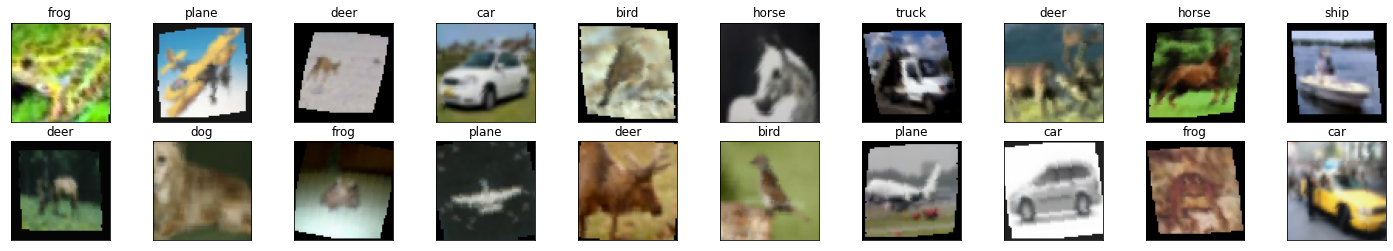

In [10]:
# We iter the batch of images to display
dataiter = iter(training_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [11]:
import hydra
from omegaconf import DictConfig
import logging

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34
from torchvision import transforms
from tqdm import tqdm
import glob

class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super().__init__()
        self.enc = base_encoder(pretrained=False)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))
        self.fc1 = nn.Linear(projection_dim, 10)

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return self.fc1(projection)

    

In [12]:
import torch
model = SimCLR(eval('resnet18'), projection_dim=128)
model.load_state_dict(
        torch.load("v10-0/simclr_resnet18.pt", map_location="cpu"), strict = False
    )
model.to(CFG.device) # run our model on cuda GPU for faster results
print("")

In [13]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002) # fine tuned the lr

In [14]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
LOGGER.info('Step,Train Loss,Train Auc,Valid Loss,Valid Auc')
for e in range(epochs): # training our model, put input according to every batch.
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    train_num = 0
    val_num = 0

    tqdm_bar = tqdm(training_loader, desc=f'Training Epoch {e} ', total=int(len(training_loader)))
    for i, (inputs, labels) in enumerate(tqdm_bar):
        inputs = inputs.to(CFG.device) # input to device as our model is running in mentioned device.
        labels = labels.to(CFG.device)
        
        model.train()
        outputs = model(inputs) # every batch of 100 images are put as an input.
        loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 

        optimizer.zero_grad() #setting the initial gradient to 0
        loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
        
        train_num += len(preds)
        
        tqdm_bar.set_postfix(train_loss=running_loss/(i+1), train_accuracy=running_corrects.item()/(train_num))
    else:
        with torch.no_grad(): # we do not need gradient for validation.
            tqdm_bar = tqdm(validation_loader, desc=f'Validation Epoch {e} ', total=int(len(validation_loader)))
            for i, (val_inputs, val_labels) in enumerate(tqdm_bar):
                val_inputs = val_inputs.to(CFG.device)
                val_labels = val_labels.to(CFG.device)
                
                #t = torch.randint(0, 4000, (len(val_labels),), device=dist_util.dev()).long()
                model.eval()
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
                val_num += len(val_preds)
                
                tqdm_bar.set_postfix(val_loss=val_running_loss/(i+1), val_accuracy=val_running_corrects.item()/(val_num))
      
        epoch_loss = running_loss/len(training_loader) # loss per epoch
        epoch_acc = running_corrects.float()/ train_num # accuracy per epoch
        running_loss_history.append(epoch_loss) # appending for displaying 
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ val_num
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        # LOGGER.info('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        # LOGGER.info('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        LOGGER.info('{:d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format((e+1) * len(training_loader), epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

Step,Train Loss,Train Auc,Valid Loss,Valid Auc
Validation Epoch 0 : 100%|██████████| 40/40 [00:05<00:00,  7.12it/s, val_accuracy=0.666, val_loss=0.997]
196, 1.0481, 0.6249, 0.9971, 0.6662


epoch : 1
training loss: 1.0481, acc 0.6249 
validation loss: 0.9971, validation acc 0.6662 


Validation Epoch 1 : 100%|██████████| 40/40 [00:05<00:00,  7.09it/s, val_accuracy=0.788, val_loss=0.623]
392, 0.6888, 0.7643, 0.6229, 0.7881


epoch : 2
training loss: 0.6888, acc 0.7643 
validation loss: 0.6229, validation acc 0.7881 


Validation Epoch 2 : 100%|██████████| 40/40 [00:05<00:00,  7.05it/s, val_accuracy=0.788, val_loss=0.637]
588, 0.5651, 0.8043, 0.6375, 0.7884


epoch : 3
training loss: 0.5651, acc 0.8043 
validation loss: 0.6375, validation acc 0.7884 


Validation Epoch 3 : 100%|██████████| 40/40 [00:05<00:00,  7.00it/s, val_accuracy=0.773, val_loss=0.706]
784, 0.4908, 0.8308, 0.7059, 0.7730


epoch : 4
training loss: 0.4908, acc 0.8308 
validation loss: 0.7059, validation acc 0.7730 


Validation Epoch 4 : 100%|██████████| 40/40 [00:05<00:00,  7.13it/s, val_accuracy=0.833, val_loss=0.488]
980, 0.4421, 0.8492, 0.4876, 0.8334


epoch : 5
training loss: 0.4421, acc 0.8492 
validation loss: 0.4876, validation acc 0.8334 


Validation Epoch 5 : 100%|██████████| 40/40 [00:05<00:00,  6.99it/s, val_accuracy=0.856, val_loss=0.433]
1176, 0.4005, 0.8638, 0.4330, 0.8564


epoch : 6
training loss: 0.4005, acc 0.8638 
validation loss: 0.4330, validation acc 0.8564 


Validation Epoch 6 : 100%|██████████| 40/40 [00:05<00:00,  7.06it/s, val_accuracy=0.822, val_loss=0.538]
1372, 0.3628, 0.8761, 0.5382, 0.8219


epoch : 7
training loss: 0.3628, acc 0.8761 
validation loss: 0.5382, validation acc 0.8219 


Validation Epoch 7 : 100%|██████████| 40/40 [00:05<00:00,  7.08it/s, val_accuracy=0.867, val_loss=0.39] 
1568, 0.3314, 0.8860, 0.3897, 0.8665


epoch : 8
training loss: 0.3314, acc 0.8860 
validation loss: 0.3897, validation acc 0.8665 


Validation Epoch 8 : 100%|██████████| 40/40 [00:05<00:00,  7.10it/s, val_accuracy=0.866, val_loss=0.416]
1764, 0.3088, 0.8949, 0.4163, 0.8658


epoch : 9
training loss: 0.3088, acc 0.8949 
validation loss: 0.4163, validation acc 0.8658 


Validation Epoch 9 : 100%|██████████| 40/40 [00:05<00:00,  7.03it/s, val_accuracy=0.881, val_loss=0.373]
1960, 0.2851, 0.9016, 0.3726, 0.8808


epoch : 10
training loss: 0.2851, acc 0.9016 
validation loss: 0.3726, validation acc 0.8808 


Validation Epoch 10 : 100%|██████████| 40/40 [00:05<00:00,  7.03it/s, val_accuracy=0.835, val_loss=0.53] 
2156, 0.2689, 0.9055, 0.5299, 0.8352


epoch : 11
training loss: 0.2689, acc 0.9055 
validation loss: 0.5299, validation acc 0.8352 


Validation Epoch 11 : 100%|██████████| 40/40 [00:05<00:00,  7.06it/s, val_accuracy=0.889, val_loss=0.337]
2352, 0.2535, 0.9132, 0.3371, 0.8892


epoch : 12
training loss: 0.2535, acc 0.9132 
validation loss: 0.3371, validation acc 0.8892 


Validation Epoch 12 : 100%|██████████| 40/40 [00:05<00:00,  7.14it/s, val_accuracy=0.881, val_loss=0.372]
2548, 0.2331, 0.9196, 0.3718, 0.8814


epoch : 13
training loss: 0.2331, acc 0.9196 
validation loss: 0.3718, validation acc 0.8814 


Validation Epoch 13 : 100%|██████████| 40/40 [00:05<00:00,  7.08it/s, val_accuracy=0.893, val_loss=0.337]
2744, 0.2197, 0.9232, 0.3369, 0.8933


epoch : 14
training loss: 0.2197, acc 0.9232 
validation loss: 0.3369, validation acc 0.8933 


Validation Epoch 14 : 100%|██████████| 40/40 [00:05<00:00,  7.07it/s, val_accuracy=0.9, val_loss=0.314]  
2940, 0.2071, 0.9282, 0.3144, 0.9002


epoch : 15
training loss: 0.2071, acc 0.9282 
validation loss: 0.3144, validation acc 0.9002 


Validation Epoch 15 : 100%|██████████| 40/40 [00:05<00:00,  6.92it/s, val_accuracy=0.898, val_loss=0.333]
3136, 0.1944, 0.9327, 0.3331, 0.8982


epoch : 16
training loss: 0.1944, acc 0.9327 
validation loss: 0.3331, validation acc 0.8982 


Validation Epoch 16 : 100%|██████████| 40/40 [00:05<00:00,  7.18it/s, val_accuracy=0.9, val_loss=0.332]  
3332, 0.1809, 0.9380, 0.3319, 0.9005


epoch : 17
training loss: 0.1809, acc 0.9380 
validation loss: 0.3319, validation acc 0.9005 


Validation Epoch 17 : 100%|██████████| 40/40 [00:05<00:00,  7.04it/s, val_accuracy=0.9, val_loss=0.331]  
3528, 0.1786, 0.9371, 0.3312, 0.9004


epoch : 18
training loss: 0.1786, acc 0.9371 
validation loss: 0.3312, validation acc 0.9004 


Validation Epoch 18 : 100%|██████████| 40/40 [00:05<00:00,  7.11it/s, val_accuracy=0.905, val_loss=0.309]
3724, 0.1636, 0.9438, 0.3090, 0.9055


epoch : 19
training loss: 0.1636, acc 0.9438 
validation loss: 0.3090, validation acc 0.9055 


Validation Epoch 19 : 100%|██████████| 40/40 [00:05<00:00,  7.10it/s, val_accuracy=0.913, val_loss=0.289]
3920, 0.1534, 0.9468, 0.2889, 0.9128


epoch : 20
training loss: 0.1534, acc 0.9468 
validation loss: 0.2889, validation acc 0.9128 


Validation Epoch 20 : 100%|██████████| 40/40 [00:05<00:00,  7.15it/s, val_accuracy=0.905, val_loss=0.326]
4116, 0.1493, 0.9483, 0.3261, 0.9050


epoch : 21
training loss: 0.1493, acc 0.9483 
validation loss: 0.3261, validation acc 0.9050 


Validation Epoch 21 : 100%|██████████| 40/40 [00:05<00:00,  7.07it/s, val_accuracy=0.915, val_loss=0.277]
4312, 0.1408, 0.9516, 0.2767, 0.9150


epoch : 22
training loss: 0.1408, acc 0.9516 
validation loss: 0.2767, validation acc 0.9150 


Validation Epoch 22 : 100%|██████████| 40/40 [00:05<00:00,  6.98it/s, val_accuracy=0.907, val_loss=0.326]
4508, 0.1262, 0.9562, 0.3255, 0.9075


epoch : 23
training loss: 0.1262, acc 0.9562 
validation loss: 0.3255, validation acc 0.9075 


Validation Epoch 23 : 100%|██████████| 40/40 [00:05<00:00,  7.14it/s, val_accuracy=0.917, val_loss=0.267]
4704, 0.1292, 0.9549, 0.2673, 0.9166


epoch : 24
training loss: 0.1292, acc 0.9549 
validation loss: 0.2673, validation acc 0.9166 


Validation Epoch 24 : 100%|██████████| 40/40 [00:05<00:00,  6.96it/s, val_accuracy=0.916, val_loss=0.296]
4900, 0.1162, 0.9599, 0.2957, 0.9160


epoch : 25
training loss: 0.1162, acc 0.9599 
validation loss: 0.2957, validation acc 0.9160 
